In [6]:
! pip install tensorboard

In [7]:
import transformers as ppb
''' For DistilBERT: samller, faster, cheaper, lighter 40% less parameters than bert-base-uncased
    run 60% faster
    95% of BERT's performance as meassured on the GLUE language understanding benchmark. 
'''
# Create tuple for DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, "distilbert-base-uncased")
# Load pretrained model andtokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
# bert = model_class.from_pretrained(pretrained_weights)

In [8]:
import pandas as pd
import numpy as np  
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score
import time

import warnings 
warnings.filterwarnings('ignore')
import gc
import copy
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Load the TensorBoard notebook extension
%load_ext tensorboard
############## TENSORBOARD ########################
import sys
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('tensorboard/runs')
###################################################

def getDevice(device):
  if device != 'cpu':
    is_cuda =  torch.cuda.is_available()
    if is_cuda:
      return torch.device('cuda')
    return torch.device('cpu')
  return torch.device('cpu')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# # Create the BertClassfier class
# class BertClassifier(nn.Module):
#     """Bert Model for Classification Tasks.
#     """
#     def __init__(self, freeze_bert=False):
#         """
#         @param    bert: a BertModel object
#         @param    classifier: a torch.nn.Module classifier
#         @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
#         """
#         super(BertClassifier, self).__init__()
#         # Specify hidden size of BERT, hidden size of our classifier, and number of labels
#         bertView_out = 768
#         bertTitle_out = 768
#         bertTitleReview_out = 768
#         input_size = 36

#         h0 = 1024
#         h1 = 512
#         h2 = 128
#         h3 = 64
#         # h4 = 32
#         out = 1

#         titleReviewIn = bertTitle_out + bertTitleReview_out + input_size
#         titleReviewOut = bertTitle_out + bertTitleReview_out + input_size + 2
#         concatenate = h3 + bertView_out
#         concatenate1 = concatenate + 2

        

#         self.bert_reviews = model_class.from_pretrained(pretrained_weights)
#         self.title = model_class.from_pretrained(pretrained_weights)
#         self.title_review = model_class.from_pretrained(pretrained_weights)

#         self.l1 = nn.Linear(titleReviewIn, titleReviewOut)
#         self.act1 = nn.ReLU()
#         self.d1 = nn.Dropout(p=0.5)

#         self.l2 = nn.Linear(titleReviewOut, h0)
#         self.act2 = nn.ReLU()
#         self.d2 = nn.Dropout(p=0.5)

#         self.l3 = nn.Linear(h0, h1)
#         self.act3 = nn.ReLU()
#         self.d3 = nn.Dropout(p=0.2)

#         self.l4 = nn.Linear(h1, h1)
#         self.act4 = nn.ReLU()
#         self.d4 = nn.Dropout(p=0.2)

#         self.l5 = nn.Linear(h1, h2)
#         self.act5 = nn.ReLU()
#         self.d5 = nn.Dropout(p=0.2)

#         self.l6 = nn.Linear(h2, h3)
#         self.act6 = nn.ReLU()
#         self.d6 = nn.Dropout(p=0.2)


#         self.l7 = nn.Linear(concatenate,  concatenate1)
#         self.act7 = nn.ReLU()
#         self.d7 = nn.Dropout(p=0.5)


#         self.l8 = nn.Linear(concatenate1 , h1 )
#         self.act8 = nn.ReLU()
#         self.d8 = nn.Dropout(p=0.5)

#         self.l9 = nn.Linear(h1 , h2 )
#         self.act9 = nn.ReLU()
#         self.d9 = nn.Dropout(p=0.2)

#         self.l10 = nn.Linear(h2 , h2 )
#         self.act10 = nn.ReLU()
#         self.d10 = nn.Dropout(p=0.2)

#         self.l11 = nn.Linear(h2 , h3 )
#         self.act11 = nn.ReLU()
#         self.d11 = nn.Dropout(p=0.2)

#         self.l12 = nn.Linear(h3 , 1 )
    

#         self.out = nn.Sigmoid()


#         # Freeze the BERT model
#         if freeze_bert:
#             for param in self.bert_reviews.parameters():
#                 param.requires_grad = False

#             for param in self.title.parameters():
#                 param.requires_grad = False

#             for param in self.title_review.parameters():
#                 param.requires_grad = False
        
#     def forward(self, reviews, title, title_review, inputs):
#         """
#         Feed input to BERT and the classifier to compute logits.
#         @param    reviews (obj) : ** keword argument [batch_size, hidden layer bert model : 512, output bert model 768]
#         @param    inputs (torch.Tensor): Category(30) + Ranking(5) + Verified Purchased(1) 
#         @return   logits (torch.Tensor): an output tensor with shape (batch_size,
#                       num_labels)
#         """
#         # Feed input to BERT
#         bert_reviews = self.bert_reviews(**reviews)
#         title = self.title(**title)
#         title_review = self.title_review(**title_review)

#         bert_reviews_state_cls = bert_reviews['last_hidden_state'][:, 0, :]
#         bert_title_state_cls = title['last_hidden_state'][:, 0, :]
#         bert_title_review_state_cls = title_review['last_hidden_state'][:, 0, :]

#         concatenate1 = torch.cat((bert_title_state_cls, bert_title_review_state_cls, inputs), 1)
#         out = self.l1(concatenate1)
#         out = self.act1(out)
#         out = self.d1(out)

#         out = self.l2(out)
#         out = self.act2(out)
#         out = self.d2(out)

#         out = self.l3(out)
#         out = self.act3(out)
#         out = self.d3(out)

#         out = self.l4(out)
#         out = self.act4(out)
#         out = self.d4(out)

#         out = self.l5(out)
#         out = self.act5(out)
#         out = self.d5(out)

#         out = self.l6(out)
#         out = self.act6(out)
#         out = self.d6(out)

#         concatenate2 = torch.cat((out, bert_reviews_state_cls), 1)
#         out = self.l7(concatenate2)
#         out = self.act7(out)
#         out = self.d7(out)

#         out = self.l8(out)
#         out = self.act8(out)
#         out = self.d8(out)

#         out = self.l9(out)
#         out = self.act9(out)
#         out = self.d9(out)

#         out = self.l10(out)
#         out = self.act10(out)
#         out = self.d10(out)

#         out = self.l11(out)
#         out = self.act11(out)
#         out = self.d11(out)

#         out = self.l12(out)

#         return self.out(out)

Title + Product  R1

Title + title review  R2

concat(R1, R2, reviews)

In [9]:
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        bertView_out = 768
        bertTitle_out = 768
        bertTitleReview_out = 768
        input_size = 39

        h0 = 1024
        h1 = 512
        h2 = 128
        h3 = 64
        h4 = 32
        out = 1

        R1 = input_size + bertTitle_out
        R2 = bertTitle_out + bertTitleReview_out
        R3 = h2
        final = bertView_out + h4
        
        self.bert_reviews = model_class.from_pretrained(pretrained_weights)
        self.title = model_class.from_pretrained(pretrained_weights)
        self.title_review = model_class.from_pretrained(pretrained_weights)
        
        # R1
        self.rl1 = nn.Linear(R1, h1)
        self.ract1 = nn.ReLU()
        self.rd1 = nn.Dropout(p=0.5)

        self.rl2 = nn.Linear(h1, h1)
        self.ract2 = nn.ReLU()
        self.rd2 = nn.Dropout(p=0.5)

        self.rl3 = nn.Linear(h1, h2)
        self.ract3 = nn.ReLU()
        self.rd3 = nn.Dropout(p=0.5)

        self.rl4 = nn.Linear(h2, h2)
        self.ract4 = nn.ReLU()
        self.rd4 = nn.Dropout(p=0.5)

        self.rl5 = nn.Linear(h2, h3)
        self.ract5 = nn.ReLU()
        self.rd5 = nn.Dropout(p=0.5)

        self.rl6 = nn.Linear(h3, h3)
        self.ract6 = nn.ReLU()
        self.rd6 = nn.Dropout(p=0.5)

        # R2
        self.r2l1 = nn.Linear(R2, h0)
        self.r2act1 = nn.ReLU()
        self.r2d1 = nn.Dropout(p=0.5)

        self.r2l2 = nn.Linear(h0, h0)
        self.r2act2 = nn.ReLU()
        self.r2d2 = nn.Dropout(p=0.5)

        self.r2l3 = nn.Linear(h0, h1)
        self.r2act3 = nn.ReLU()
        self.r2d3 = nn.Dropout(p=0.5)

        self.r2l4 = nn.Linear(h1, h1)
        self.r2act4 = nn.ReLU()
        self.r2d4 = nn.Dropout(p=0.5)

        self.r2l5 = nn.Linear(h1, h2)
        self.r2act5 = nn.ReLU()
        self.r2d5 = nn.Dropout(p=0.5)

        self.r2l6 = nn.Linear(h2, h2)
        self.r2act6 = nn.ReLU()
        self.r2d6 = nn.Dropout(p=0.5)

        self.r2l7 = nn.Linear(h2, h3)
        self.r2act7 = nn.ReLU()
        self.r2d7 = nn.Dropout(p=0.5)

        # R3
        self.r3l1 = nn.Linear(R3, h3)
        self.r3act1 = nn.ReLU()
        self.r3d1 = nn.Dropout(p=0.5)

        self.r3l2 = nn.Linear(h3, h3)
        self.r3act2 = nn.ReLU()
        self.r3d2 = nn.Dropout(p=0.5)

        self.r3l3 = nn.Linear(h3, h3)
        self.r3act3 = nn.ReLU()
        self.r3d3 = nn.Dropout(p=0.5)

        self.r3l4 = nn.Linear(h3, h4)
        self.r3act4 = nn.ReLU()
        self.r3d4 = nn.Dropout(p=0.5)

        # Final
        self.finall1 = nn.Linear(final, h1)
        self.finalact1 = nn.ReLU()
        self.finald1 = nn.Dropout(p=0.5)

        self.finall2 = nn.Linear(h1, h1)
        self.finalact2 = nn.ReLU()
        self.finald2 = nn.Dropout(p=0.5)

        self.finall3 = nn.Linear(h1, h2)
        self.finalact3 = nn.ReLU()
        self.finald3 = nn.Dropout(p=0.5)

        self.finall4 = nn.Linear(h2, h2)
        self.finalact4 = nn.ReLU()
        self.finald4 = nn.Dropout(p=0.5)

        self.finall5 = nn.Linear(h2, h3)
        self.finalact5 = nn.ReLU()
        self.finald5 = nn.Dropout(p=0.5)

        self.finall6 = nn.Linear(h3, h4)
        self.finalact6 = nn.ReLU()
        self.finald6 = nn.Dropout(p=0.5)

        self.finall17 = nn.Linear(h4, out )
        self.out = nn.Sigmoid()

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert_reviews.parameters():
                param.requires_grad = False

            for param in self.title.parameters():
                param.requires_grad = False

            for param in self.title_review.parameters():
                param.requires_grad = False
        
    def forward(self, bert,  inputs):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    reviews (obj) : ** keword argument [batch_size, hidden layer bert model : 512, output bert model 768]
        @param    inputs (torch.Tensor): Category(30) + Ranking(5) + Verified Purchased(1) 
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
  
        # Feed input to BERT
        bert_reviews = self.bert_reviews(**bert["reviewText"])
        title = self.title(**bert["productTitle"])
        title_review = self.title_review(**bert["reviewTitle"])

        bert_reviews_state_cls = bert_reviews['last_hidden_state'][:, 0, :]
        bert_title_state_cls = title['last_hidden_state'][:, 0, :]
        bert_title_review_state_cls = title_review['last_hidden_state'][:, 0, :]

        R1 = torch.cat((bert_title_state_cls, inputs), 1)

        or1 = self.rl1(R1)
        or1 = self.ract1(or1)
        or1 = self.rd1(or1)

        or1 = self.rl2(or1)
        or1 = self.ract2(or1)
        or1 = self.rd2(or1)

        or1 = self.rl3(or1)
        or1 = self.ract3(or1)
        or1 = self.rd3(or1)

        or1 = self.rl4(or1)
        or1 = self.ract4(or1)
        or1 = self.rd4(or1)

        or1 = self.rl5(or1)
        or1 = self.ract5(or1)
        or1 = self.rd5(or1)

        or1 = self.rl6(or1)
        or1 = self.ract6(or1)
        or1 = self.rd6(or1)

        R2 = torch.cat((bert_title_state_cls, bert_title_review_state_cls), 1)

        or2 = self.r2l1(R2)
        or2 = self.r2act1(or2)
        or2 = self.r2d1(or2)

        or2 = self.r2l2(or2)
        or2 = self.r2act2(or2)
        or2 = self.r2d2(or2)

        or2 = self.r2l3(or2)
        or2 = self.r2act3(or2)
        or2 = self.r2d3(or2)

        or2 = self.r2l4(or2)
        or2 = self.r2act4(or2)
        or2 = self.r2d4(or2)

        or2 = self.r2l5(or2)
        or2 = self.r2act5(or2)
        or2 = self.r2d5(or2)

        or2 = self.r2l6(or2)
        or2 = self.r2act6(or2)
        or2 = self.r2d6(or2)

        or2 = self.r2l7(or2)
        or2 = self.r2act7(or2)
        or2 = self.r2d7(or2)

        R3 = torch.cat((or1, or2), 1)

        or3 = self.r3l1(R3)
        or3 = self.r3act1(or3)
        or3 = self.r3d1(or3)

        or3 = self.r3l2(or3)
        or3 = self.r3act2(or3)
        or3 = self.r3d2(or3)

        or3 = self.r3l3(or3)
        or3 = self.r3act3(or3)
        or3 = self.r3d3(or3)

        or3 = self.r3l4(or3)
        or3 = self.r3act4(or3)
        or3 = self.r3d4(or3)

        R3 = torch.cat((bert_reviews_state_cls, or3), 1)

        out = self.finall1(R3)
        out = self.finalact1(out)
        out = self.finald1(out)

        out = self.finall2(out)
        out = self.finalact2(out)
        out = self.finald2(out)

        out = self.finall3(out)
        out = self.finalact3(out)
        out = self.finald3(out)

        out = self.finall4(out)
        out = self.finalact4(out)
        out = self.finald4(out)

        out = self.finall5(out)
        out = self.finalact5(out)
        out = self.finald5(out)

        out = self.finall6(out)
        out = self.finalact6(out)
        out = self.finald6(out)

        out = self.finall17(out)
        return self.out(out)

In [10]:

class prepareData():
    def __init__(self):
      reviews = pd.read_csv('./final.csv')
     

      self.category_label_encoder = LabelEncoder()
      self.category_number_encoder = OneHotEncoder(sparse=False)

      category_label_encoded = self.category_label_encoder.fit_transform(reviews['PRODUCT_CATEGORY'].values)
      print(category_label_encoded.shape)
      category_label_encoded = category_label_encoded.reshape(category_label_encoded.shape[0], 1)
      print(category_label_encoded.shape)
      category_onehot_encoded = self.category_number_encoder.fit_transform(category_label_encoded)

      self.rating_onehot_encoded = OneHotEncoder(sparse=False)
      rating_onehot_encoded = self.rating_onehot_encoded.fit_transform(reviews['RATING'].values.reshape(len(reviews['RATING']), 1))
        
      reviews = self.addToPandas(category_onehot_encoded, reviews, 'category')
      reviews = self.addToPandas(rating_onehot_encoded, reviews, 'rating')

      reviews.drop(['Unnamed: 0','RATING', 'PRODUCT_CATEGORY'], axis=1, inplace=True)

      X = reviews.loc[:, ~reviews.columns.isin(["LABEL"])].values
      Y = reviews['LABEL'].values

      X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, shuffle= True, random_state = 1234 )
      X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size= 0.1, shuffle= True, random_state = 1234 )
      
      bertTrain = self.extractReviewsToInputMaskAttention(X_train)
      bertValidate = self.extractReviewsToInputMaskAttention(X_validate)
      bertTest = self.extractReviewsToInputMaskAttention(X_test)
   
      X_train = np.delete(X_train, obj=[1,2,3], axis=1)
      X_validate = np.delete(X_validate, obj=[1,2,3], axis=1)
      X_test = np.delete(X_test, obj=[1,2,3], axis=1)

      self.train = self.DatasetClass(X_train,bertTrain, y_train)
      self.validate = self.DatasetClass(X_validate,bertValidate, y_validate)
      self.test = self.DatasetClass(X_test,bertTest, y_test)

      del X, Y, bertValidate, bertTrain, bertTest
      gc.collect()

       
    def extractReviewsToInputMaskAttention(self, data):
      X_Bert_productTitle = data[:,1]
      X_Bert_reviewTitle = data[:,2]
      X_Bert_reviewText = data[:,3]

      input_ids_X_Bert_productTitle, attention_mask_X_Bert_productTitle = self.prepareDataForBert(X_Bert_productTitle)
      input_ids_X_Bert_reviewTitle, attention_mask_X_Bert_reviewTitle = self.prepareDataForBert(X_Bert_reviewTitle)
      input_ids_X_Bert_reviewText, attention_mask_X_Bert_reviewText = self.prepareDataForBert(X_Bert_reviewText)

      return {"productTitle":{"input_ids":input_ids_X_Bert_productTitle, 'attention_mask': attention_mask_X_Bert_productTitle},
              "reviewTitle":{"input_ids":input_ids_X_Bert_reviewTitle, 'attention_mask': attention_mask_X_Bert_reviewTitle},
              "reviewText":{"input_ids":input_ids_X_Bert_reviewText, 'attention_mask': attention_mask_X_Bert_reviewText}
             }
      

    def addToPandas(self, data, dataPandas, prefix=''):
      pbar = tqdm_notebook(total = data.shape[1])
      pbar.set_description(f'Data prefix {prefix}')
      
      for i in range(data.shape[1]):
        dataPandas[f'{prefix}_{i}'] = data[:, i]
        pbar.update(1)
      pbar.close()

      return dataPandas

    def prepareDataForBert(self, data):
      tokenized = []

      pbar = tqdm_notebook(total = len(data))
      pbar.set_description(f'Tokenized: ')
      for i in data:
        tokenized.append(tokenizer.encode(i, add_special_tokens = True, truncation=True))
        pbar.update(1)
      pbar.close()
    
      max_len = 0
      for i in tokenized:
        if len(i) > max_len:
          max_len = len(i)

      padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized])
      attention_mask = np.where(padded != 0, 1, 0)
      
      return padded, attention_mask
    
    class DatasetClass(Dataset):
      ''' 
        inputs => VERIFIED_PURCHASE, CATEGORY, RATING
        PRODUCT_TITLE
        REVIEW_TITLE
        REVIEW_TEXT
      '''
      def __init__(self, inputs, bert,labels):
        
        self.inputs = torch.from_numpy(np.asarray(inputs, dtype=np.int8))
        self.labels = torch.from_numpy(np.asarray(labels.reshape(labels.shape[0], 1), dtype=np.float32)).to(torch.float32)

        self.input_ids_productTitle, self.attention_mask_productTitle= torch.tensor(bert['productTitle']['input_ids']), torch.tensor(bert['productTitle']['attention_mask'])        
        self.input_ids_reviewTitle, self.attention_mask_reviewTitle = torch.tensor(bert['reviewTitle']['input_ids']), torch.tensor(bert['reviewTitle']['attention_mask'])
        self.input_ids_reviewText, self.attention_mask_reviewText = torch.tensor(bert['reviewText']['input_ids']), torch.tensor(bert['reviewText']['input_ids'])
        self.n_samples = inputs.shape[0]

   
      def __getitem__(self, index):
      
        bert = {"productTitle":{"input_ids":self.input_ids_productTitle[index], 'attention_mask': self.attention_mask_productTitle[index]},
              "reviewTitle":{"input_ids":self.input_ids_reviewTitle[index], 'attention_mask': self.attention_mask_reviewTitle[index]},
              "reviewText":{"input_ids":self.input_ids_reviewText[index], 'attention_mask': self.attention_mask_reviewText[index]}
             }
      
        return self.inputs[index], bert ,self.labels[index]
      

      def __len__(self):
        return self.n_samples 


class AI_Model():
  def __init__(self, train, validate, test, device, batch_size = 1, epoch = 1, learning_rate = 1e-3, loadModelFlag = False, loadModelFile = ''):
    self.batch_size = batch_size
    self.epoch =  epoch
    self.device = device
    

    self.train = DataLoader(dataset = train, batch_size = self.batch_size, shuffle = True)
    self.validation = DataLoader(dataset = validate, batch_size = self.batch_size, shuffle = False)
    self.test = DataLoader(dataset = test, batch_size = self.batch_size, shuffle = False)

    self.model = self.loadModel(loadModelFlag = loadModelFlag, loadModelFile = loadModelFile)
    self.lossFunction = nn.BCELoss()  
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr = learning_rate)
   
  

  def loadModel(self, loadModelFlag = False, loadModelFile = ''):
    if loadModelFlag:
      if loadModelFile != '':
        return torch.load(loadModelFile).to(self.device)
    return BertClassifier().to(self.device)


  '''
       Metrics         
  '''
  def metrics(self, y, y_hat, typeMetric = 'Acc' ):
      
      precision, recall, thresholds = precision_recall_curve(y, y_hat)

      if typeMetric == 'f1':
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.argmax(fscore)
        return  fscore[ix]
      elif typeMetric == 'recall':
        ix = np.argmax(recall)
        return recall[ix]
      elif typeMetric == 'precision':
        ix = np.argmax(precision)
        return precision[ix]
      elif typeMetric == 'AUROC':
        return roc_auc_score(y, y_hat)
      elif typeMetric == 'PRC':
        return auc(recall, precision)
      elif typeMetric == 'acc':
        return accuracy_score(y, y_hat.round()) * 100



  def trainModel(self, show_process = True, process_factor = 10, patiente = 2, typeMetric = 'acc',  earlyStopFlag=True):

    pbarEpoch = tqdm_notebook(total = self.epoch)
    pbarEpoch.set_description('Epoch: ')

    self.lossTraining = []
    self.accTraining = []
    self.lossValidation = []
    self.accValidation  = []

    patiente_acum = 0  # patiente counter

    prev_metric = -1e2  # best loss from validation
    best_Model =  copy.deepcopy(self.model.state_dict()) # best model
    self.best_epoch = 0

    for epoch in range(self.epoch):

      y_hat = []
      y = []
      flag = True

      loss_train = 0.0
      acc_train  = 0.0
      
      
      self.model.train()
      for idx, (inputs, bert, labels) in enumerate(self.train):
        inputs = inputs.to(self.device)
        labels = labels.to(self.device)
         
        bert = {"productTitle":{"input_ids": bert["productTitle"]["input_ids"].to(self.device), 'attention_mask': bert["productTitle"]["attention_mask"].to(self.device)},
              "reviewTitle":{"input_ids":bert["reviewTitle"]["input_ids"].to(self.device), 'attention_mask': bert["reviewTitle"]["attention_mask"].to(self.device)},
              "reviewText":{"input_ids": bert["reviewText"]["input_ids"].to(self.device), 'attention_mask': bert["reviewText"]["attention_mask"].to(self.device)}
             }
        
        '''
                    ---------------   Forward    --------------------
        '''
        outputs = self.model(bert, inputs)
        loss = self.lossFunction(outputs, labels)

        '''
                    ---------------   Backward    --------------------
        '''
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()
        self.optimizer.zero_grad()

        '''
                    ---------------  Get predicted to calculate accuracy ----------------
        '''
        predicted = outputs.cpu().detach().numpy()
        ground_truth = labels.cpu().detach().numpy()

        if flag:
          y_hat = predicted
          y = ground_truth
          flag = False

        y_hat = np.append(y_hat, predicted)
        y = np.append(y, ground_truth)

        acc = self.metrics(y, y_hat, typeMetric = 'acc')

        if show_process:
          if (idx + 1) % process_factor== 0:
              text = f'Training Stage ==> Epoch: {epoch} / {self.epoch - 1} | Step: {idx} / {len(self.train)} | Training loss: {loss.item():.5f} |  Training Accuracy: {acc:.5f}'
              print(text)
        
        
        loss_train = loss.item()
        acc_train = acc
        pbarEpoch.set_postfix({'Epoch':epoch,
            'training_loss': loss_train, 
            'training Acc': acc_train, 
            'Step': idx,
            'from': len(self.train)
            })

      self.lossTraining.append(loss_train)
      self.accTraining.append(acc_train)
      metric = self.metrics(y, y_hat, typeMetric = typeMetric)

      text = f'Training Stage ==> Epoch: {epoch} / {self.epoch - 1} | Training loss: {loss_train:.5f} |  Training Accuracy: {acc:.5f} | Training Metric {typeMetric}: {metric:.5f}'
      print(text)

      ############## TENSORBOARD ########################
      writer.add_scalar('Loss/Train', loss_train, epoch)
      writer.add_scalar('Accuracy/Train', acc_train, epoch)
      ###################################################
      

      del inputs, input_ids_productTitle, attention_mask_productTitle, input_ids_reviewTitle, attention_mask_reviewTitle, input_ids_reviewText, attention_mask_reviewText, labels
      torch.cuda.empty_cache()
      gc.collect()

      ''' 
                ----------------------------------  EVALUATION STAGE  ---------------------------------------
                
      '''
      y_hat = []
      y = []
      flag = True

      loss_val = 0.0
      acc_val  = 0.0
      
      
      self.model.eval()
      with torch.no_grad():
        for idx, (inputs, bert, labels) in enumerate(self.validation):
          inputs = inputs.to(self.device)
          labels = labels.to(self.device)
         
          bert = {"productTitle":{"input_ids": bert["productTitle"]["input_ids"].to(self.device), 'attention_mask': bert["productTitle"]["attention_mask"].to(self.device)},
                "reviewTitle":{"input_ids":bert["reviewTitle"]["input_ids"].to(self.device), 'attention_mask': bert["reviewTitle"]["attention_mask"].to(self.device)},
                "reviewText":{"input_ids": bert["reviewText"]["input_ids"].to(self.device), 'attention_mask': bert["reviewText"]["attention_mask"].to(self.device)}
              }
       
          '''
                    ---------------   Forward    --------------------
          '''

          outputs = self.model(bert, inputs)
          loss = self.lossFunction(outputs, labels)

          predicted = outputs.cpu().detach().numpy()
          ground_truth = labels.cpu().detach().numpy()

          if flag:
            y_hat = predicted
            y = ground_truth
            flag = False

          y_hat = np.append(y_hat, predicted)
          y = np.append(y, ground_truth)
          acc = self.metrics(y, y_hat, typeMetric = 'acc')

          if show_process:
            if (idx + 1) % process_factor== 0:
              text = f'Validation Stage ==> Epoch: {epoch} / {self.epoch - 1} | Step: {idx} / {len(self.validation)} | Validation loss: {loss.item():.5f} |  Validation Accuracy: {acc:.5f}'
              print(text)
        
        
          loss_val = loss.item()
          acc_val = acc
          pbarEpoch.set_postfix({'Epoch':epoch,
            'validation_loss': loss_val, 
            'Validation Acc': acc_val, 
            'Step': idx,
            'from': len(self.validation)
            })
        
        self.lossValidation.append(loss_val)
        self.accValidation.append(acc_val)
        metric = self.metrics(y, y_hat, typeMetric = typeMetric)
        text = f'Validation Stage ==> Epoch: {epoch} / {self.epoch - 1} | Validation loss: {loss_val:.5f} |  Validation Accuracy: {acc:.5f} | Validation Metric {typeMetric}: {metric:.5f}'
        print(text)

        ############## TENSORBOARD ########################
        writer.add_scalar('Loss/Validation', loss_val, epoch)
        writer.add_scalar('Accuracy/Validation', acc_val, epoch)
        ###################################################

        if ~math.isnan(metric) or metric == 0:
          if metric > prev_metric:
            prev_metric = metric
            best_Model =  copy.deepcopy(self.model.state_dict())
            torch.save(self.model, f'./model/model_EPOCH_{epoch}')

            np.save(f'./training/lossTraining_EPOCH_{epoch}',np.asarray(self.lossTraining))
            np.save(f'./training/accTraining_EPOCH_{epoch}',np.asarray(self.accTraining))
            np.save(f'./training/lossValidation_EPOCH_{epoch}',np.asarray(self.lossValidation))
            np.save(f'./training/accValidation_EPOCH_{epoch}',np.asarray(self.accValidation))
          
    
            self.best_epoch = epoch
            patiente_acum = 0
          else:
            patiente_acum += 1
        else:
            patiente_acum += 1


        if earlyStopFlag and patiente_acum > patiente:
          # Load best model in current model
          self.model.load_state_dict(best_Model)
          
          print(f'Early Stop Load Model from best epoch {self.best_epoch}')
          break
      

      
      pbarEpoch.set_postfix({'Epoch':epoch,
            'training_loss': loss_train, 
            f'training Acc': acc_train, 
            'validate_loss': loss_val, 
            f'Validation Acc': acc_val, 
            'patiente': patiente_acum,
            f'Metric {typeMetric}': metric
            })



      del inputs, input_ids_productTitle, attention_mask_productTitle, input_ids_reviewTitle, attention_mask_reviewTitle, input_ids_reviewText, attention_mask_reviewText, labels, productTitle, reviewTitle, reviewText
      torch.cuda.empty_cache()
      gc.collect()

    if ~earlyStopFlag:
      # Load best model in current model
      self.model.load_state_dict(best_Model)
      print(f'Load Model from best epoch {self.best_epoch}') 

      pbarEpoch.update(1)
    pbarEpoch.close()


  def testingModel(self, dataset):
    
    torch.cuda.empty_cache()
    gc.collect()

    y_hat = []
    y = []
    flag = True

    lossTest = 0.0
    accTest  = 0.0

    self.model.eval()
    with torch.no_grad():
        for idx, (inputs, bert, labels) in enumerate(dataset):
          inputs = inputs.to(self.device)
          labels = labels.to(self.device)
         
          bert = {"productTitle":{"input_ids": bert["productTitle"]["input_ids"].to(self.device), 'attention_mask': bert["productTitle"]["attention_mask"].to(self.device)},
                "reviewTitle":{"input_ids":bert["reviewTitle"]["input_ids"].to(self.device), 'attention_mask': bert["reviewTitle"]["attention_mask"].to(self.device)},
                "reviewText":{"input_ids": bert["reviewText"]["input_ids"].to(self.device), 'attention_mask': bert["reviewText"]["attention_mask"].to(self.device)}
              }
        
          '''
                    ---------------   Forward    --------------------
          '''
          outputs = self.model(bert, inputs)
          loss = self.lossFunction(outputs, labels)

          predicted = outputs.cpu().detach().numpy()
          ground_truth = labels.cpu().detach().numpy()

          if flag:
            y_hat = predicted
            y = ground_truth
            flag = False

          y_hat = np.append(y_hat, predicted)
          y = np.append(y, ground_truth)
          lossTest = loss.item()
          accTest = self.metrics(y, y_hat, typeMetric = 'acc')

        text = f'Loss: {lossTest:.5f} |  Validation Accuracy: {accTest:.5f}'
        print(text)
        return y, y_hat

def plot_Accuracy_Loss_Training_Curves(accTraining, accValidation, lossTraining, lossValidation):
    fig, ax = plt.subplots()
    ax.plot(accValidation, label =f'Validation', color='b')
    ax.plot(accTraining, label =f'Training', color='orange')
    # ax.axvline(x = self.best_epoch, color = 'r',  label = 'Epoch')
    ax.set(xlabel='Epoch', ylabel='Accuracy')
    ax.legend(loc="lower right")
    ax.set_ylim((10, 105))
        
    fig1, ax1 = plt.subplots()
    ax1.plot(lossValidation, label =f'Validation', color='b')
    ax1.plot( lossTraining, label =f'Training', color='orange')
    # ax1.axvline(x = self.best_epoch, color = 'r', label = 'Epoch')
    ax1.set(xlabel='Epoch', ylabel='Loss')
    ax1.legend(loc="lower right")
    ax1.set_ylim((0, 1))
    plt.show()

def plot_Confusion_Matrix(y, y_hat):
    labels = [0, 1]
    confusion_Matrix = confusion_matrix(y, y_hat)
    sns.heatmap(confusion_Matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
    xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title(f"Confusion Matrix")
    plt.show()


def to_labels(pos_probs, threshold):
  return (pos_probs >= threshold).astype('int')
     
def testModel_GetThreshold(y, y_hat, typeData = 'f1'):
  torch.cuda.empty_cache()
  thresholds = np.arange(0, 1, 0.001)

  if typeData == 'f1':
    scores = [f1_score(y, to_labels(y_hat, t)) for t in thresholds]
    ix = np.argmax(scores)
    return thresholds[ix], scores[ix]
  elif typeData == 'AUROC':
    scores = [roc_auc_score(y, to_labels(y_hat, t)) for t in thresholds]
    ix = np.argmax(scores)
    return thresholds[ix], scores[ix]
  elif typeData == 'recall':
    scores = [recall_score(y, to_labels(y_hat, t)) for t in thresholds]
    ix = np.argmax(scores)
    return thresholds[ix], scores[ix]
  elif typeData == 'PRC':
    scores = []
    for t in thresholds:
      precision, recall, _ = precision_recall_curve(y, to_labels(y_hat, t))
      scores.append(auc(recall, precision))
    scores = np.array(scores)
    ix = np.argmax(scores)
         
    return thresholds[ix], scores[ix]

def getGmean(y, y_hat):
  fpr, tpr, _ = roc_curve(y, y_hat)
  G_mean = np.sqrt(tpr * (1 - fpr))
  G_mean_index = np.argmax(G_mean)
  print(f"G-mean = {G_mean[G_mean_index]}")
  return G_mean[G_mean_index]

def adjustDataByThreshold(y_hat, threshold):
  y_hat[y_hat >= threshold] = 1
  y_hat[y_hat < threshold] = 0
  return y_hat

def ROC_Curve(y, y_hat):
  roc_auc_DNN = roc_auc_score(y, y_hat)
  print(f'AUC : {roc_auc_DNN}')
  # false positive rate, true positive rate
  fpr, tpr, _ = roc_curve(y, y_hat)
        
  plt.figure()
  plt.title('Receiver operating characteristic (ROC)')
  plt.plot(fpr, tpr, label=f'AUC (area = {roc_auc_DNN:.3f})', marker = '.')
  plt.fill_between(fpr, tpr, alpha=0.4)
  plt.plot([0,1],[0,1],'r--')
  plt.xlim([-0.01, 1.0])
  plt.ylim([-0.01, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()

def PRC_curves(y, y_hat):
  torch.cuda.empty_cache() 
        # Train Dataset
  
  presicionTrain, recallTrain, _  = precision_recall_curve(y, y_hat)
  auc_Train = auc(recallTrain, presicionTrain)
  print(f'AUC : {auc_Train}')

  f1_Train = (2 * presicionTrain * recallTrain) / (presicionTrain + recallTrain)
  

  ix_Train = np.argmax(f1_Train)
  f1_Train = f1_Train[ix_Train]


  fig1, ax =plt.subplots()
  ax.plot(recallTrain, presicionTrain, label=f'Test Dataset: {auc_Train:.4f}', marker = '.')
  ax.fill_between(recallTrain, presicionTrain, alpha=0.4)


  ax.set_xlim([-0.01, 1.05])
  ax.set_ylim([-0.01, 1.05])
  ax.set(title = 'Precision - Recall Curve', xlabel ='Recall', ylabel='Precision')
  ax.legend(loc='lower left') 
  plt.show()

  gc.collect()
  
def test_Report(y, y_hat):
  tn, fp, fn, tp = confusion_matrix(y, y_hat).ravel()
  acc = (tp + tn) / (tn + fp + fn + tp)
  precision = tp/(tp +fp)
  recall = tp / (tp + fn)
  f1_score = 2*(precision *recall) / (precision +recall)
  print('accuracy: ', acc)
  print('precision: ', precision)
  print('recall: ', recall)
  print('f1_score: ', f1_score)
  classificationReport = classification_report( y, y_hat, target_names=['real', 'fake'])
  print(classificationReport)




In [11]:
device = getDevice('gpu')
dataset = prepareData()
# dataset.reviews_original.head(3)

(21000,)
(21000, 1)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15120 [00:00<?, ?it/s]

  0%|          | 0/15120 [00:00<?, ?it/s]

  0%|          | 0/15120 [00:00<?, ?it/s]

  0%|          | 0/1680 [00:00<?, ?it/s]

  0%|          | 0/1680 [00:00<?, ?it/s]

  0%|          | 0/1680 [00:00<?, ?it/s]

  0%|          | 0/4200 [00:00<?, ?it/s]

  0%|          | 0/4200 [00:00<?, ?it/s]

  0%|          | 0/4200 [00:00<?, ?it/s]

In [12]:
train = dataset.train
validate = dataset.validate
test = dataset.test

__LEARNING_RATE__ = 2e-5
__EPOCH__ = 1000

torch.cuda.empty_cache()
gc.collect()

modelTest = AI_Model(train, validate, test, device, batch_size = 1, epoch = __EPOCH__, learning_rate = __LEARNING_RATE__)
# modelTest.trainModel(show_process = True, process_factor = 1000, patiente = 2, typeMetric = 'AUROC',  earlyStopFlag=True)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- T

In [13]:
modelTest = AI_Model(train, validate, test, device, batch_size = 4,loadModelFlag = True, loadModelFile = './model_EPOCH_46.pt')

In [14]:
torch.cuda.empty_cache()
gc.collect()
y, y_hat = modelTest.testingModel(modelTest.test)

Loss: 0.50544 |  Validation Accuracy: 85.01427


AUC : 0.9125632724100041


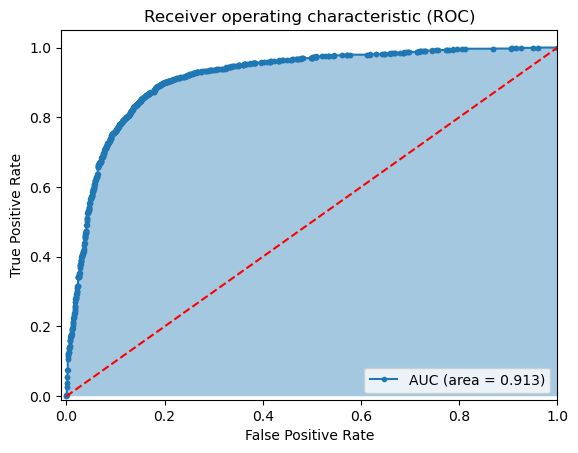

In [15]:
ROC_Curve(y, y_hat)

AUC : 0.897373095891639


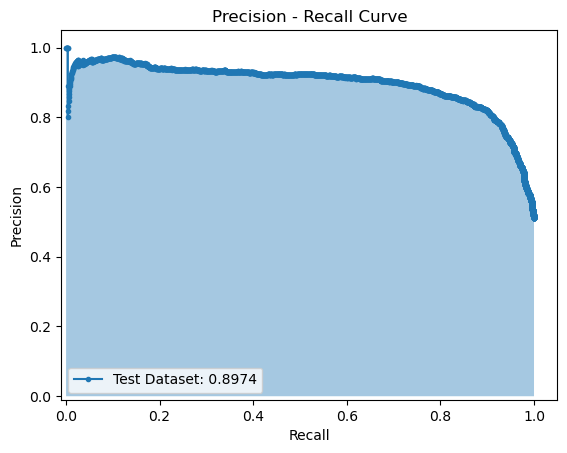

In [16]:
PRC_curves(y, y_hat)

In [21]:
test_Report(y, y_hat)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [17]:
threshold, metric = testModel_GetThreshold(y, y_hat, typeData = 'AUROC')
print(threshold, metric )

0.47300000000000003 0.8515193865645783


In [19]:
threshold, metric = testModel_GetThreshold(y, y_hat, typeData = 'f1')
print(threshold, metric )

0.395 0.8581785228817399


In [22]:
gmean = getGmean(y, y_hat)
y_hat_gmean = adjustDataByThreshold(y_hat, gmean)

G-mean = 0.8509473292621241


In [23]:
threshold = 0.395
y_hat_th = adjustDataByThreshold(y_hat, threshold)

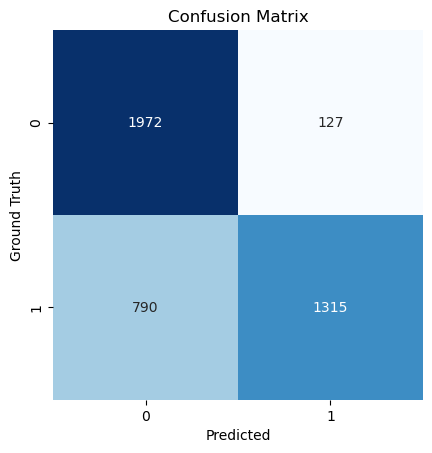

In [24]:
plot_Confusion_Matrix(y, y_hat_th)

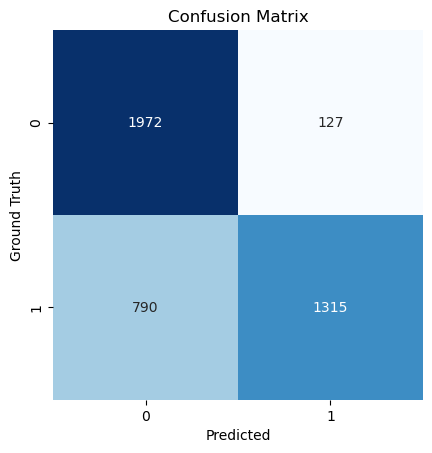

In [25]:
threshold = 0.47300000000000003
y_hat_th11 = adjustDataByThreshold(y_hat, threshold)
plot_Confusion_Matrix(y, y_hat_th11)

In [26]:
threshold = 0.5
y_hat_th45 = adjustDataByThreshold(y_hat, threshold)

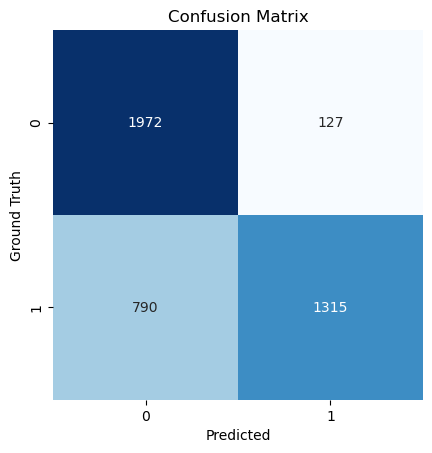

In [27]:

plot_Confusion_Matrix(y, y_hat_th45)

        
        

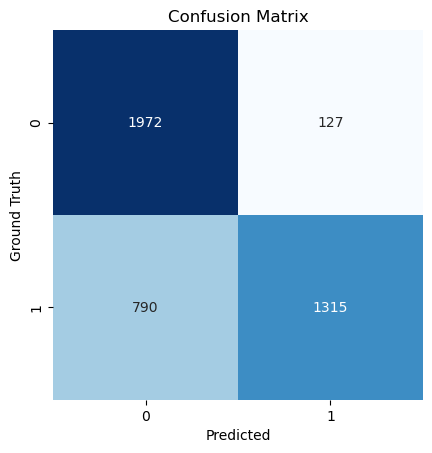

In [29]:
threshold = 0.9
y_hat_th11 = adjustDataByThreshold(y_hat, threshold)
plot_Confusion_Matrix(y, y_hat_th11)


In [32]:
train = dataset.train
validate = dataset.validate
test = dataset.test

__LEARNING_RATE__ = 2e-5
__EPOCH__ = 1000

torch.cuda.empty_cache()
gc.collect()

modelTest1 = AI_Model(train, validate, test, device, batch_size = 4,loadModelFlag = True, loadModelFile = './model_EPOCH_22.pt')
# modelTest.trainModel(show_process = True, process_factor = 1000, patiente = 2, typeMetric = 'AUROC',  earlyStopFlag=True)